# Intra-Annual Sea Level Anomalies
Monthly mean sea level anomalies. This page is very much in development!!

```{caution}
Major updates are needed for this page. Don't look at it too hard...
```


## Setup

As with previous sections, we first need to import the necessary libraries, establish our input/output directories, and set up some basic plotting rules. We'll do this by running another notebook called "setup" and "plotting functions," and then we'll set our data and output paths. 

In [1]:
%run ../setup.ipynb
%run ../plotting_functions.ipynb
# data_dir = Path('../../data' )
# output_dir = Path('../../output')
# output_dir =  

In [2]:
#show me what is in the data_dir path
print("Files in the data directory: ", [f for f in data_dir.iterdir() if f.is_file()])

Files in the data directory:  [PosixPath('/Users/juliafiedler/Documents/SL_Hawaii_data/data/cmems_L4_SSH_0.125deg_1993_2024_pacific_OLD.nc'), PosixPath('/Users/juliafiedler/Documents/SL_Hawaii_data/data/.DS_Store'), PosixPath('/Users/juliafiedler/Documents/SL_Hawaii_data/data/rsl_daily_hawaii.nc'), PosixPath('/Users/juliafiedler/Documents/SL_Hawaii_data/data/rsl_hawaii.nc'), PosixPath('/Users/juliafiedler/Documents/SL_Hawaii_data/data/asl_hawaii.nc'), PosixPath('/Users/juliafiedler/Documents/SL_Hawaii_data/data/rsl_daily_pacific.nc'), PosixPath('/Users/juliafiedler/Documents/SL_Hawaii_data/data/rsl_hawaii_noaa.nc'), PosixPath('/Users/juliafiedler/Documents/SL_Hawaii_data/data/asl_pacific.nc'), PosixPath('/Users/juliafiedler/Documents/SL_Hawaii_data/data/cmems_L4_SSH_0.125deg_1993_2024.nc'), PosixPath('/Users/juliafiedler/Documents/SL_Hawaii_data/data/cmems_L4_SSH_0.125deg_1993_2024_pacific.nc'), PosixPath('/Users/juliafiedler/Documents/SL_Hawaii_data/data/rsl_pacific.nc')]


### Import the tide gauge data

In [3]:
#import rsl_daily
rsl_daily = xr.open_dataset(data_dir/ 'rsl_daily_pacific.nc')

#make rsl_daily a subset - do not include TGs with more than 25% NaNs
# get percent Nans in rsl_daily['sea_level']

rsl_daily

<xarray.Dataset> Size: 468kB
Dimensions:       (record_id: 2, time: 11688)
Coordinates:
  * record_id     (record_id) int64 16B 25 38
  * time          (time) datetime64[ns] 94kB 1993-01-01 ... 2024-12-31
    lat           (record_id) float32 8B ...
    lon           (record_id) float32 8B ...
    station_name  (record_id) <U10 80B ...
    storm_time    (time) datetime64[ns] 94kB ...
Data variables:
    rsl_anomaly   (record_id, time) float32 94kB ...
    rsl_mhhw      (record_id, time) float64 187kB ...
Attributes:
    long_name:  Sea Level Anomaly
    units:      m
    source:     in situ tide gauge water level observations
    platform:   station_name, station_country, station_country_code, uhslc_id...
    epoch:      1993-2001

### check the data and drop all stations with less than 80% coverage

In [4]:
data_coverage = rsl_daily.rsl_mhhw.count(dim='time')/len(rsl_daily.time)

#drop all locations with data_coverage less than 80%
rsl_subset = rsl_daily.where(data_coverage>0.80,drop=True)

rsl_subset

<xarray.Dataset> Size: 468kB
Dimensions:       (record_id: 2, time: 11688)
Coordinates:
  * record_id     (record_id) int64 16B 25 38
  * time          (time) datetime64[ns] 94kB 1993-01-01 ... 2024-12-31
    lat           (record_id) float32 8B -8.525 -21.13
    lon           (record_id) float32 8B 179.2 184.8
    station_name  (record_id) <U10 80B 'Funafuti' "Nuku'alofa"
    storm_time    (time) datetime64[ns] 94kB ...
Data variables:
    rsl_anomaly   (record_id, time) float32 94kB nan nan nan ... 0.06776 -0.2833
    rsl_mhhw      (record_id, time) float64 187kB nan nan nan ... -0.469 -0.82
Attributes:
    long_name:  Sea Level Anomaly
    units:      m
    source:     in situ tide gauge water level observations
    platform:   station_name, station_country, station_country_code, uhslc_id...
    epoch:      1993-2001

In [5]:
# get the record min and max for each TG by month
record_min = rsl_subset.groupby('time.month').min()
record_max = rsl_subset.groupby('time.month').max()

record_min

<xarray.Dataset> Size: 496B
Dimensions:       (month: 12, record_id: 2)
Coordinates:
  * record_id     (record_id) int64 16B 25 38
    lat           (record_id) float32 8B -8.525 -21.13
    lon           (record_id) float32 8B 179.2 184.8
    station_name  (record_id) <U10 80B 'Funafuti' "Nuku'alofa"
  * month         (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    rsl_anomaly   (month, record_id) float32 96B -0.2393 -0.4983 ... -0.2833
    rsl_mhhw      (month, record_id) float64 192B -0.9755 -1.035 ... -0.82
Attributes:
    long_name:  Sea Level Anomaly
    units:      m
    source:     in situ tide gauge water level observations
    platform:   station_name, station_country, station_country_code, uhslc_id...
    epoch:      1993-2001

In [14]:
rsl_monthly_mean['rsl_anomaly']

<xarray.DataArray 'rsl_anomaly' (month: 12, record_id: 2)> Size: 96B
array([[ 0.06025722,  0.08400803],
       [ 0.08227862,  0.09100521],
       [ 0.08656318,  0.08847341],
       [ 0.06880748,  0.06564221],
       [ 0.02818333,  0.0268701 ],
       [-0.00666478,  0.01371069],
       [-0.02483529,  0.00756929],
       [-0.01918433,  0.00253919],
       [-0.01228559,  0.00488227],
       [ 0.01033817,  0.02061534],
       [ 0.0238288 ,  0.0496581 ],
       [ 0.03579571,  0.07338998]], dtype=float32)
Coordinates:
  * record_id     (record_id) int64 16B 25 38
    lat           (record_id) float32 8B -8.525 -21.13
    lon           (record_id) float32 8B 179.2 184.8
    station_name  (record_id) <U10 80B 'Funafuti' "Nuku'alofa"
  * month         (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:  Sea Level Anomaly
    units:      m
    source:     in situ tide gauge water level observations
    platform:   station_name, station_country, station_country_code, uhslc_id...
    epoch:      1993-2001

/Users/juliafiedler/anaconda3/envs/SLI39/lib/python3.9/site-packages/xarray/groupers.py:326: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


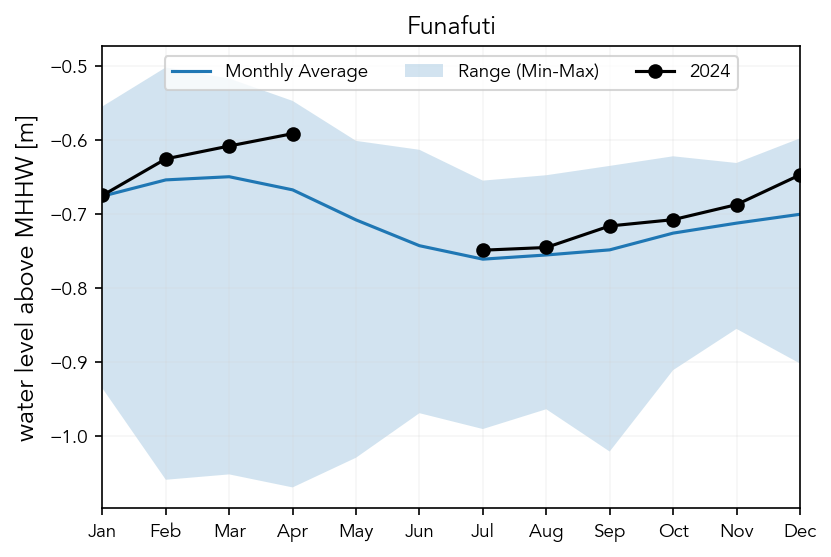

In [17]:
# Resample the data to get monthly means and squeeze any singleton dimensions
rsl_monthly = rsl_subset.resample(time='1M').mean().squeeze()

# Calculate monthly statistics: mean, minimum, and maximum
rsl_monthly_mean = rsl_monthly.sel(time=slice('1993-01-01', '2024-12-31')).groupby('time.month').mean()
rsl_monthly_min = rsl_monthly.sel(time=slice('1993-01-01', '2024-12-31')).groupby('time.month').min()
rsl_monthly_max = rsl_monthly.sel(time=slice('1993-01-01', '2024-12-31')).groupby('time.month').max()

# select which station to plot
rid = 0

# Plot the average sea level for each month
ax = rsl_monthly_mean['rsl_mhhw'].isel(record_id=rid).plot(label='Monthly Average')


# Add shaded area between min and max values for each month
plt.fill_between(rsl_monthly_min.month, 
                 rsl_monthly_min['rsl_mhhw'].isel(record_id=rid), 
                 rsl_monthly_max['rsl_mhhw'].isel(record_id=rid), 
                 alpha=0.2, label='Range (Min-Max)')




# Add 2022 monthly values on top of the average
rsl_2024 = rsl_monthly.sel(time=slice('2024-01-01', '2024-12-31')).squeeze()
plt.plot(np.arange(1, 13), rsl_2024['rsl_mhhw'].isel(record_id=rid).values, 
         color='black', label='2024', marker='o')

# Customize the x-axis to show month names instead of numbers
plt.xticks(np.arange(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Set labels and title
# plt.ylabel('Sea Level Anomaly (m)')
plt.xlabel('')
plt.title(rsl_monthly_mean['station_name'].isel(record_id=rid).values)

# Adjust x-axis limits and add a grid
plt.xlim(1, 12)
# plt.ylim(-0.45, -0.05)
plt.grid(alpha=0.2, color='lightgray')

# Add a legend at the top in 3 columns
plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1))

# Save the plot to a file
plt.savefig(output_dir / 'SL_MMMA_intra_pacific.png', dpi=300, bbox_inches='tight')

fig = plt.gcf()

glue("SL_MMA_intra",fig,display=False)


```{glue:figure} SL_MMA_intra
:name: "SL_MMA_intra"

Monthly means at the Honolulu tide gauge for the epoch 1983-2001. Note that the sea level is plotted in units of m, relative to {glue:text}`datumname`. Note also that this differs from the plot available at https://uhslc.soest.hawaii.edu/stations/?stn=057#climatology, because we are using records only from the epoch. 
```

In [18]:
rsl_monthly

<xarray.Dataset> Size: 12kB
Dimensions:       (time: 384, record_id: 2)
Coordinates:
  * record_id     (record_id) int64 16B 25 38
    lat           (record_id) float32 8B -8.525 -21.13
    lon           (record_id) float32 8B 179.2 184.8
    station_name  (record_id) <U10 80B 'Funafuti' "Nuku'alofa"
  * time          (time) datetime64[ns] 3kB 1993-01-31 1993-02-28 ... 2024-12-31
Data variables:
    rsl_anomaly   (time, record_id) float32 3kB nan -0.07532 ... 0.089 0.05649
    rsl_mhhw      (time, record_id) float64 6kB nan -0.612 ... -0.6472 -0.4802
Attributes:
    long_name:  Sea Level Anomaly
    units:      m
    source:     in situ tide gauge water level observations
    platform:   station_name, station_country, station_country_code, uhslc_id...
    epoch:      1993-2001

````{margin}
```{note}
TO DO: Make relative to MHHW? Add lastest year. Make plot with all TGs on it.
```
````

## Absolute Value: satellite (trend removed)

In [20]:
# open the cmems data
cmems = xr.open_dataset(data_dir / 'cmems_L4_SSH_0.125deg_1993_2024_pacific.nc')

In [21]:
def process_trend_with_nan(sea_level_anomaly):
    # Flatten the data and get a time index
    # first ensure time is the first dimension regardless of other dimensions
    sea_level_anomaly = sea_level_anomaly.transpose('time', ...)
    sla_flat = sea_level_anomaly.values.reshape(sea_level_anomaly.shape[0], -1)
    time_index = pd.to_datetime(sea_level_anomaly.time.values).to_julian_date()

    detrended_flat = np.full_like(sla_flat, fill_value=np.nan)

    # Loop over each grid point
    for i in range(sla_flat.shape[1]):
        # Get the time series for this grid point
        y = sla_flat[:,i]
        mask = ~np.isnan(y)

        if np.any(mask):
            time_masked = time_index[mask]
            y_masked = y[mask]

            slope, intercept, _, _, _ = stats.linregress(time_masked, y_masked)
            trend = slope * time_index + intercept

            detrended_flat[:,i] = y - trend

    detrended = detrended_flat.reshape(sea_level_anomaly.shape)

    # Calculate trend magnitude
    sea_level_trend = sea_level_anomaly - detrended
    trend_mag = sea_level_trend[-1] - sea_level_trend[0]

    times = pd.to_datetime(sea_level_anomaly['time'].values)
    time_mag = (times[-1] - times[0]).days/365.25 # in years

    trend_rate = trend_mag / time_mag

    return trend_mag, sea_level_trend, trend_rate  

### Plot an area-wide map, with stations
First we'll need to make sure that our data is detrended properly in order to look at monthly anomalies.

```{margin}
```{caution}
Come back and check this. Also note: need to add stations on here. #TODO
```
```

In [22]:
# remove long term trend from rsl using polynomial fit
trend_mag_cmems, trend_line_cmems, trend_rate_cmems = process_trend_with_nan(cmems.sla)

cmems_detrended = cmems.sla - trend_line_cmems

# make a cmems monthly mean for plotting
cmems_monthly = cmems_detrended.resample(time='1ME').mean().squeeze()

# get the mean for each month of the year
cmems_climatology = cmems_monthly.groupby('time.month').mean(dim='time')

cmems_mmsla = cmems_monthly.groupby('time.month') - cmems_climatology


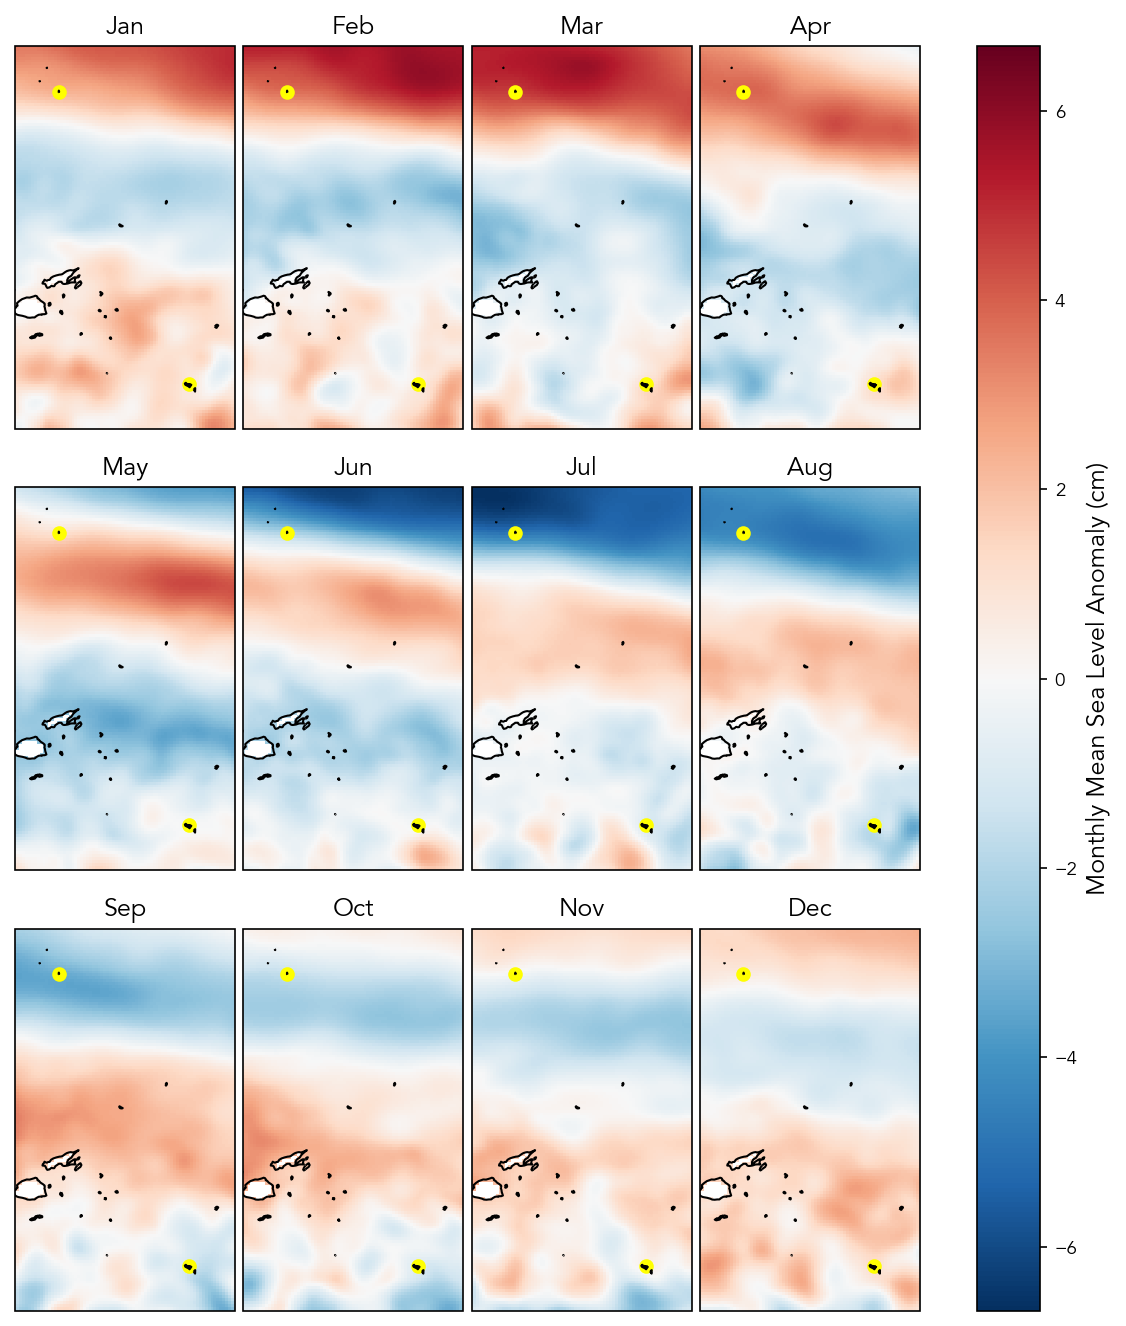

In [35]:
# plot the monthly_anomalies*100 for centimeters
cmems_cm = cmems_climatology * 100

# convert cmems_cm.month to datetime object
months = pd.to_datetime(cmems_cm.month.values, format='%m').strftime('%b')


# Plot the data with modified titles
mma = cmems_cm.plot(transform=ccrs.PlateCarree(), col='month', col_wrap=4,
                        aspect=cmems_cm.sizes['longitude'] / cmems_cm.sizes['latitude'],
                        subplot_kws={'projection': ccrs.PlateCarree(central_longitude=180)},)

# Add coastlines and land features to each subplot
for i,ax in enumerate(mma.axs.flat):
    ax.coastlines()
    #ax.add_feature(cfeature.LAND, color='black')
    # add station location
    ax.scatter(rsl_monthly_mean['lon'].values, 
               rsl_monthly_mean['lat'].values, 
               color='yellow', marker='o',transform = ccrs.PlateCarree())
    ax.set_title(months[i])
    ax.set_extent([cmems_cm.longitude.min(), cmems_cm.longitude.max(),  cmems_cm.latitude.min(), cmems_cm.latitude.max()]) 

# change the colorbar label
mma.cbar.set_label('Monthly Mean Sea Level Anomaly (cm)')  

#assign mma to a figure
fig = plt.gcf()

#save the figure
fig.savefig(output_dir / 'SL_anomaly_map_pacific.png', dpi=300)

glue("mma_asl_fig", fig, display=False)



```{glue:figure} mma_asl_fig
:name: "mma-asl-fig"
Map of absolute monthly mean sea level anomalies from altimetry for the full record from {glue:text}`station_group`, {glue:text}`country` station from {glue:text}`startDateTime` to {glue:text}`endDateTime`.
```


## Relative Value: tide station (trend removed)
### area-wide map with stations
### station plots: time series  
These should have ONI/ENSO phase included on them

In [38]:
rsl_monthly

<xarray.Dataset> Size: 12kB
Dimensions:       (time: 384, record_id: 2)
Coordinates:
  * record_id     (record_id) int64 16B 25 38
    lat           (record_id) float32 8B -8.525 -21.13
    lon           (record_id) float32 8B 179.2 184.8
    station_name  (record_id) <U10 80B 'Funafuti' "Nuku'alofa"
  * time          (time) datetime64[ns] 3kB 1993-01-31 1993-02-28 ... 2024-12-31
Data variables:
    rsl_anomaly   (time, record_id) float32 3kB nan -0.07532 ... 0.089 0.05649
    rsl_mhhw      (time, record_id) float64 6kB nan -0.612 ... -0.6472 -0.4802
Attributes:
    long_name:  Sea Level Anomaly
    units:      m
    source:     in situ tide gauge water level observations
    platform:   station_name, station_country, station_country_code, uhslc_id...
    epoch:      1993-2001

In [36]:
def process_trend_with_nan(sea_level_anomaly):
    # Flatten the data and get a time index
    # first ensure time is the first dimension regardless of other dimensions
    sea_level_anomaly = sea_level_anomaly.transpose('time', ...)
    sla_flat = sea_level_anomaly.values.reshape(sea_level_anomaly.shape[0], -1)
    time_index = pd.to_datetime(sea_level_anomaly.time.values).to_julian_date()

    detrended_flat = np.full_like(sla_flat, fill_value=np.nan)

    # Loop over each grid point
    for i in range(sla_flat.shape[1]):
        # Get the time series for this grid point
        y = sla_flat[:,i]
        mask = ~np.isnan(y)

        if np.any(mask):
            time_masked = time_index[mask]
            y_masked = y[mask]

            slope, intercept, _, _, _ = stats.linregress(time_masked, y_masked)
            trend = slope * time_index + intercept

            detrended_flat[:,i] = y - trend

    detrended = detrended_flat.reshape(sea_level_anomaly.shape)

    # Calculate trend magnitude
    sea_level_trend = sea_level_anomaly - detrended
    trend_mag = sea_level_trend[-1] - sea_level_trend[0]

    times = pd.to_datetime(sea_level_anomaly['time'].values)
    time_mag = (times[-1] - times[0]).days/365.25 # in years

    trend_rate = trend_mag / time_mag

    return trend_mag, sea_level_trend, trend_rate  

In [39]:
# remove long-term trend from rsl_monthly
trend_mag_rsl, trend_line_rsl, trend_rate_rsl = process_trend_with_nan(rsl_monthly.rsl_anomaly)

rsl_monthly_detrended = rsl_monthly.rsl_anomaly - trend_line_rsl

# add detrended rsl_monthly to rsl_monthly
rsl_monthly['sea_level_detrended'] = rsl_monthly_detrended
rsl_monthly['sea_level_detrended'].attrs = {'long_name': 'sea level anomaly', 'units': 'm'}

In [40]:
# remove annual cycle from rsl_monthly
rsl_monthly_detrended = rsl_monthly_detrended.groupby('time.month') - rsl_monthly_detrended.groupby('time.month').mean(dim='time')

# add to rsl_monthly
rsl_monthly['sea_level_detrended_anom'] = rsl_monthly_detrended
rsl_monthly['sea_level_detrended_anom'].attrs = {'long_name': 'monthly mean sea level anomaly', 'units': 'm'}

## Make a plot

In [41]:
rsl_monthly.sel(record_id=25)

<xarray.Dataset> Size: 14kB
Dimensions:                   (time: 384)
Coordinates:
    record_id                 int64 8B 25
    lat                       float32 4B -8.525
    lon                       float32 4B 179.2
    station_name              <U10 40B 'Funafuti'
  * time                      (time) datetime64[ns] 3kB 1993-01-31 ... 2024-1...
    month                     (time) int64 3kB 1 2 3 4 5 6 7 ... 7 8 9 10 11 12
Data variables:
    rsl_anomaly               (time) float32 2kB nan nan ... 0.04885 0.089
    rsl_mhhw                  (time) float64 3kB nan nan ... -0.6874 -0.6472
    sea_level_detrended       (time) float32 2kB nan nan ... -0.04961 -0.009827
    sea_level_detrended_anom  (time) float32 2kB nan nan ... -0.04388 -0.01569
Attributes:
    long_name:  Sea Level Anomaly
    units:      m
    source:     in situ tide gauge water level observations
    platform:   station_name, station_country, station_country_code, uhslc_id...
    epoch:      1993-2001

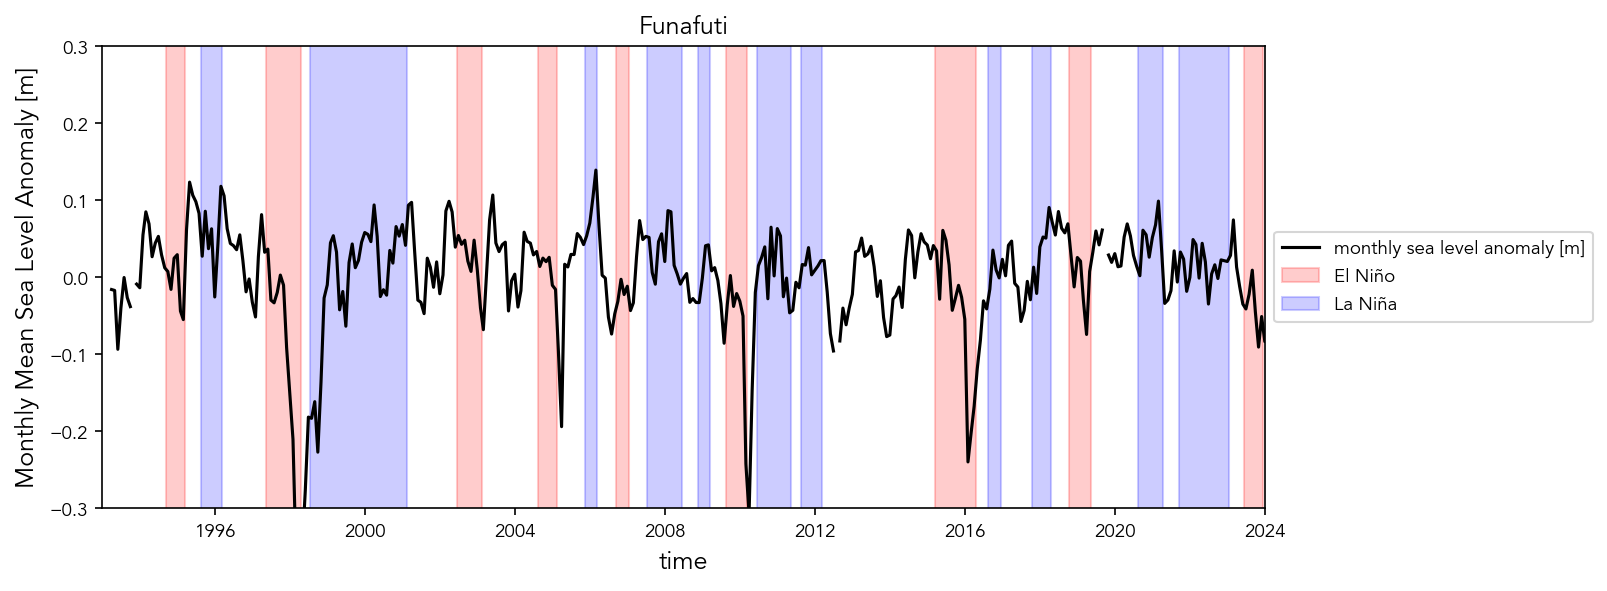

In [47]:
# get axis for the plots
fig,ax = plt.subplots(1,1,figsize=(10,4), sharex=True, sharey=True)

# add ENSO to the plots
# import oni.csv
oni = pd.read_csv(data_dir/'climate_indices'/'oni_bool.csv',header=0)
# change oni index to Date column
oni.index = pd.to_datetime(oni['Date'] )

rid = 25

rsl_monthly['sea_level_detrended_anom'].sel(record_id=rid).plot.line(ax=ax, x='time', label='monthly sea level anomaly [m]', color='black')
# Shading El Niño events
ax.fill_between(oni.index, oni['ONI'].min(), oni['ONI'].max(), 
                where=oni['El Nino'] == 1, color='red', alpha=0.2, label='El Niño')
# Shading La Niña events
ax.fill_between(oni.index, oni['ONI'].min(), oni['ONI'].max(), 
                where=oni['La Nina'] == 1, color='blue', alpha=0.2, label='La Niña')

ax.set_xlim([dt.datetime(1993,1,1),dt.datetime(2024,1,1)])
ax.set_ylim([-0.3,0.3])
ax.set_title(rsl_monthly['station_name'].sel(record_id=rid).values)
ax.set_ylabel('Monthly Mean Sea Level Anomaly [m]')

 #put legend on the side
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#save the figure
fig.savefig(output_dir / 'SL_anomaly_timseries_pacific.png', dpi=300)
glue("SL_anomaly_timeseries_honolulu_fig", fig, display=False)

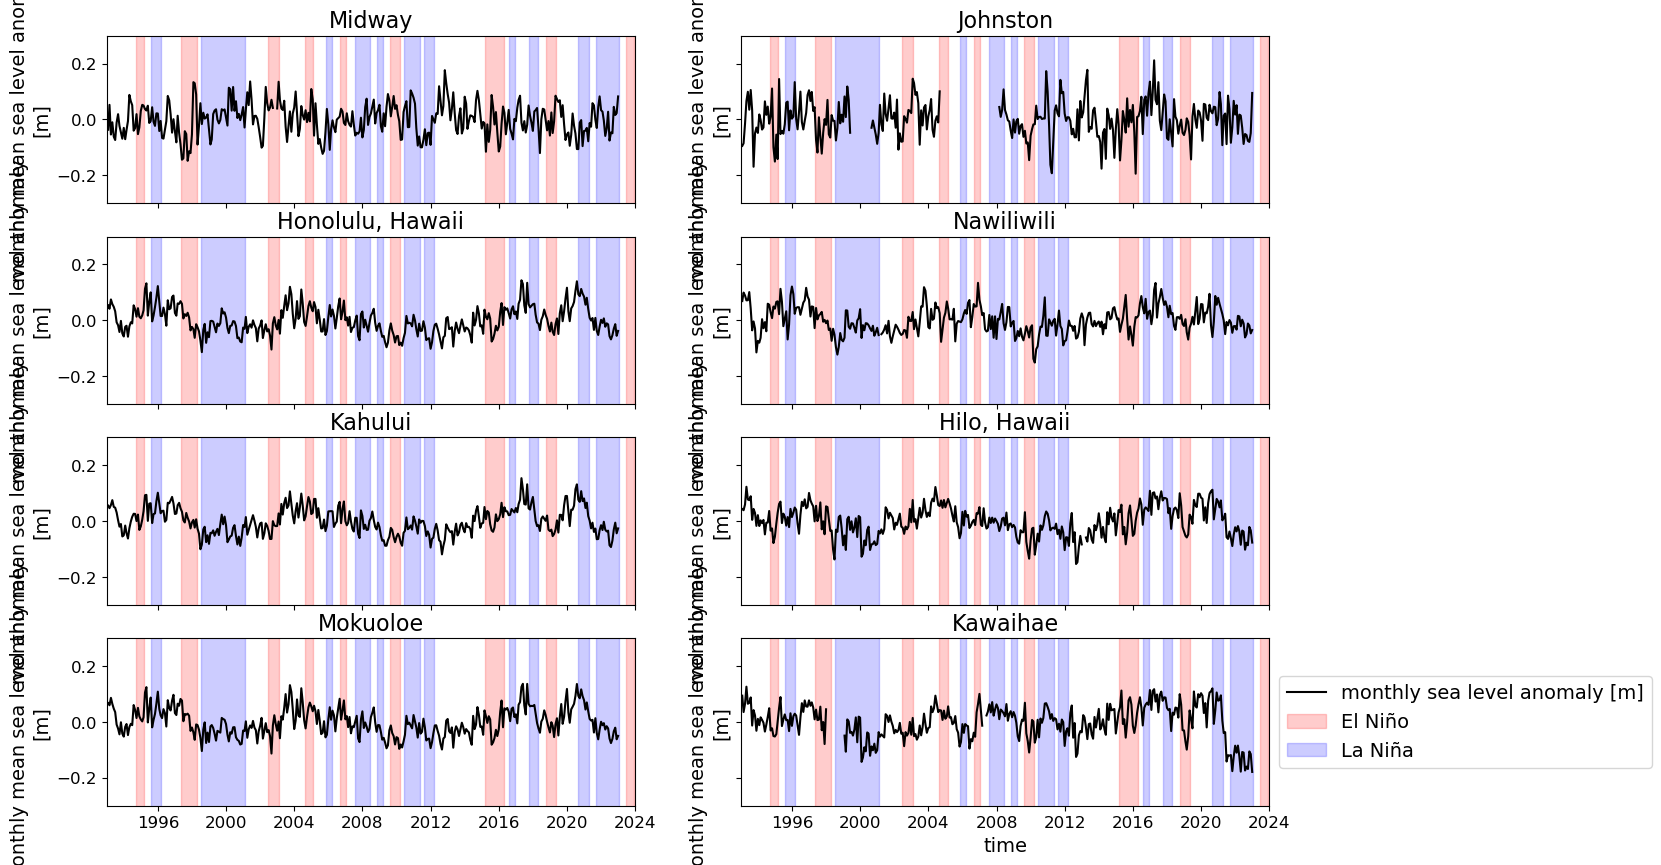

In [ ]:

# get axis for the plots
fig,axes = plt.subplots(4,2,figsize=(15,10), sharex=True, sharey=True)
axes = axes.flatten()

# add ENSO to the plots
# import oni.csv
oni = pd.read_csv(data_dir/'oni.csv',header=0)
# change oni index to Date column
oni.index = pd.to_datetime(oni['Date'] )

record_ids = rsl_monthly['sea_level_detrended_anom'].record_id.values

# iterate over each axis and plot the monthly mean
for i in range(len(record_ids)):
    ax = axes[i]
    rsl_monthly['sea_level_detrended_anom'].isel(record_id=i).plot.line(ax=ax, x='time', label='monthly sea level anomaly [m]', color='black')

    # Shading El Niño events
    ax.fill_between(oni.index, oni['ONI'].min(), oni['ONI'].max(), 
                    where=oni['El Nino'] == 1, color='red', alpha=0.2, label='El Niño')

    # Shading La Niña events
    ax.fill_between(oni.index, oni['ONI'].min(), oni['ONI'].max(), 
                    where=oni['La Nina'] == 1, color='blue', alpha=0.2, label='La Niña')
    
    ax.set_xlim([dt.datetime(1993,1,1),dt.datetime(2024,1,1)])
    ax.set_ylim([-0.3,0.3])

    ax.set_title(rsl_monthly['station_name'].values[i])

    if i < 7:
        ax.set_xlabel('')

#put legend on the side
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#save the figure
fig.savefig(output_dir / 'SL_anomaly_timseries_stations.png', dpi=300)

glue("SL_anomaly_timeseries_stations_fig", fig, display=False)


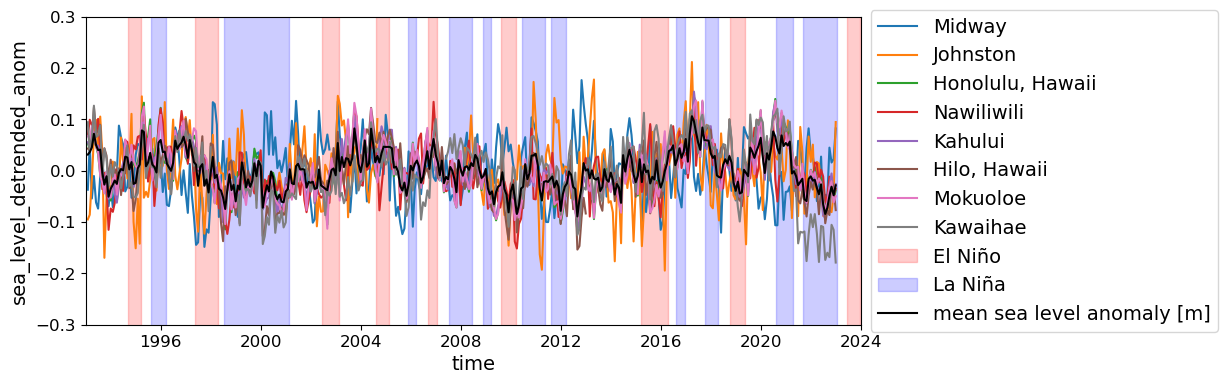

In [ ]:
# make the same plot but only on one axis
fig,ax = plt.subplots()


rsl_monthly['sea_level_detrended_anom'].plot.line(x='time', label=rsl_monthly['station_name'].values)

# add ONI shading
# Shading El Niño events
ax.fill_between(oni.index, oni['ONI'].min(), oni['ONI'].max(), 
                where=oni['El Nino'] == 1, color='red', alpha=0.2, label='El Niño')

# Shading La Niña events
ax.fill_between(oni.index, oni['ONI'].min(), oni['ONI'].max(), 
                where=oni['La Nina'] == 1, color='blue', alpha=0.2, label='La Niña')

ax.set_xlim([dt.datetime(1993,1,1),dt.datetime(2024,1,1)])
ax.set_ylim([-0.3,0.3])

#put the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_title('Monthly Mean Sea Level Anomalies (1993-2023)')

# add mean sea level anomaly to the plot
rsl_monthly['sea_level_detrended_anom'].mean(dim='record_id').plot.line(x='time', label='mean sea level anomaly [m]', color='black')

#update the legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#save the figure
fig.savefig(output_dir / 'SL_anomaly_timeseries.png', dpi=300)

glue("SL_anomaly_timeseries_fig", fig, display=False)


```{glue:figure} SL_anomaly_timeseries_fig
:name: "SL_anomaly_timeseries"
Plot of absolute monthly mean sea level anomalies from altimetry for the full record from {glue:text}`station_group`, {glue:text}`country` station from {glue:text}`startDateTime` to {glue:text}`endDateTime`.
```
